# Markov graph clustering

### Importing libraries

In [2]:
# Numpy
import numpy as np
from numpy import concatenate, array
from numpy.random import randn

# Matplotlib
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
%matplotlib inline
#mpl.rc('figure', figsize=(10, 8))

# DBscan from sklearn
from sklearn import cluster, datasets
from sklearn.cluster import DBSCAN
from sklearn import metrics
print 'All libraries loaded.'

All libraries loaded.


In [3]:
# import pygraphviz
import networkx as nx
import matplotlib.pyplot as plt

def draw_graph(graph, labels=None, graph_layout='circular',
               node_size=800, node_color='blue', node_alpha=0.3,
               node_text_size=12,
               edge_color='blue', edge_alpha=0.3, edge_tickness=1,
               edge_text_pos=0.3,
               text_font='sans-serif'):

    # Define size of the figure
    plt.figure(num=None, figsize=(18.0, 14.0), dpi=580, facecolor='w', edgecolor='k')
    
    # create networkx graph
    G=nx.Graph()

    # add edges
    for edge in graph:
        G.add_edge(edge[0], edge[1])

    # these are different layouts for the network you may try
    # shell seems to work best
    if graph_layout == 'spring':
        graph_pos=nx.spring_layout(G)
    elif graph_layout == 'spectral':
        graph_pos=nx.spectral_layout(G)
    elif graph_layout == 'circular':
        graph_pos=nx.circular_layout(G)
    elif graph_layout == 'random':
        graph_pos=nx.random_layout(G)
    elif graph_layout == 'graphviz':
        graph_pos=nx.graphviz_layout(G)
    else:
        graph_pos=nx.shell_layout(G)

    # draw graph
    nx.draw_networkx_nodes(G,graph_pos,node_size=node_size, 
                           alpha=node_alpha, node_color=node_color)
    nx.draw_networkx_edges(G,graph_pos,width=edge_tickness,
                           alpha=edge_alpha,edge_color=edge_color)
    nx.draw_networkx_labels(G, graph_pos,font_size=node_text_size,
                            font_family=text_font)

    if labels is None:
        labels = range(len(graph))

    # show graph
    plt.show()
    
def draw_graph2(G, A, cluster_map):
    import networkx as nx
    import matplotlib.pyplot as plt

    clust_map = {}
    for k, vals in cluster_map.items():
        for v in vals:
            clust_map[v] = k

    colors = []
    for i in range(len(G.nodes())):
        colors.append(clust_map.get(i, 100))

    pos = nx.spring_layout(G)

    from matplotlib.pylab import matshow, show, cm
    plt.figure(2)
    nx.draw_networkx_nodes(G, pos,node_size = 200, node_color =colors , cmap=plt.cm.Blues )
    nx.draw_networkx_edges(G,pos, alpha=0.5)
    matshow(A, fignum=1, cmap=cm.gray)
    plt.show()
    show()

### Reading from the AT&T dataset

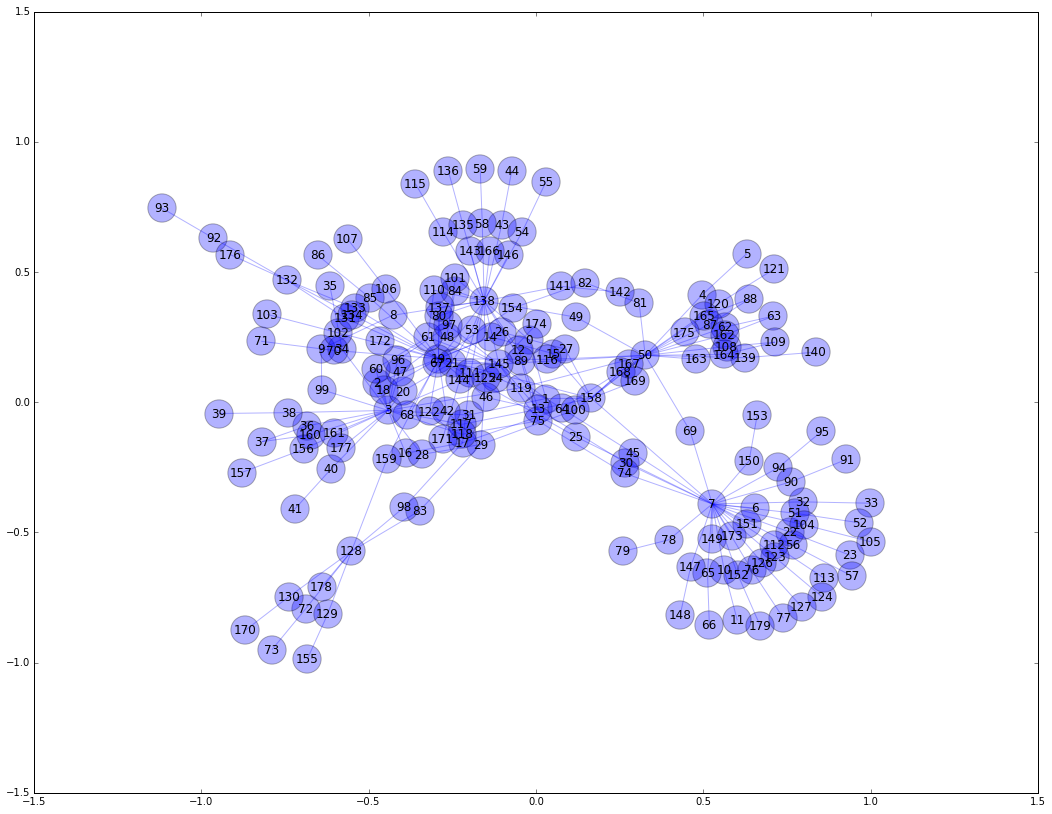

In [91]:
# Configurations for parameters
R = 2.0
pruning_threshold = 0.002
matrix_power_parameter = 2
convergence_tolerance = 0.00000001

def getAdjacencyMatrixFromDataset(filePath):
    # Read from the file
    originalGraph = np.loadtxt(filePath, delimiter=' ', dtype=int)
    
    # Draw graph of original values
    draw_graph(originalGraph, graph_layout='spring')
    
    # Initialize the adjacency matrix A
    numOfNodes = int(np.amax(originalGraph))
    A = np.zeros((numOfNodes, numOfNodes))
    
    for line in originalGraph:
        A[line[0]-1][line[1]-1] = 1
        A[line[1]-1][line[0]-1] = 1
        
    return A

def prune(X):
    for index in np.ndindex(X.shape):
        value = X[index]
        if value <= pruning_threshold:
            X[index] = 0
    return X

# A = getAdjacencyMatrixFromDataset("dataset/small2.txt")
A = getAdjacencyMatrixFromDataset("dataset/attweb_net.txt")

In [92]:
# Compare the 2 matrices to check for convergence
def hasConverged(X, Y):
    # Check if the matrices are equal with a tolerance of 0.001
    
    converged = True
    for i in range(0, X.shape[0]):
        for j in range(0, X.shape[1]):
            if abs(X[i][j] - Y[i][j]) > convergence_tolerance:
                converged = False
                break

#   return np.allclose(X, Y, atol=convergence_tolerance)
    return converged

# Normalization function
def normalize(X):
    return X / X.sum(axis=0)[np.newaxis, :]

# Given a transitional matrix, identify and return clusters
def identifyClusters(T):
    clusters = []
    X = (T>pruning_threshold)

    for i in range(0, X.shape[0]):
        if X[i][i]:
            # X[i] is an attractor. All nodes attracted to it form a cluster
            newCluster = [index+1 for index, x in enumerate(T[i,:]) if x>0]
            clusters.append(newCluster)

    return clusters

# Precision value to display in the matrix
np.set_printoptions(precision=5, suppress=True)

def applyMclAlgorithm(A):
    M = np.array(A)

    # Add self-loops
    for i in range(0, M.shape[0]):
        M[i][i] = 1
    print '\nAfter adding self-loops\n', M

    # Normalize
    M = normalize(M)
    print '\nAfter normalization\n', M

    # Keep an original copy
    originalM = np.array(M)

    count = 1
    maxIterations = 50
    while True:
        print '\n\n======= Iteration', count, '========'
        previousM = np.array(M)

        # Expand
        M = np.linalg.matrix_power(M, matrix_power_parameter)
        print '\nExpanding\n', M

        # Inflate
        M = np.power(M, R)
        print '\nInflating\n', M

        # Re-normalize
        M = normalize(M)
        print '\nRenormalizing\n', M

        # Pruning
        M = prune(M)
        print '\nPruning\n', M

        # Check for convergence
        if hasConverged(M, previousM) or count > maxIterations:
            break

        count = count + 1

    print "\nFinished in", count, "iterations."
    clusters = identifyClusters(M)
    return M, clusters

M, clusters = applyMclAlgorithm(A)
print '\nFinal transitional matrix\n', M
print '\nClusters identified\n', clusters


After adding self-loops
[[ 1.  0.  0. ...,  0.  0.  1.]
 [ 0.  1.  1. ...,  0.  0.  0.]
 [ 0.  1.  1. ...,  1.  0.  0.]
 ..., 
 [ 0.  0.  1. ...,  1.  0.  0.]
 [ 0.  0.  0. ...,  0.  1.  0.]
 [ 1.  0.  0. ...,  0.  0.  1.]]

After normalization
[[ 0.14286  0.       0.      ...,  0.       0.       0.25   ]
 [ 0.       0.33333  0.04348 ...,  0.       0.       0.     ]
 [ 0.       0.33333  0.04348 ...,  0.5      0.       0.     ]
 ..., 
 [ 0.       0.       0.04348 ...,  0.5      0.       0.     ]
 [ 0.       0.       0.      ...,  0.       0.5      0.     ]
 [ 0.14286  0.       0.      ...,  0.       0.       0.25   ]]


======= Iteration 1 ========

Expanding
[[ 0.22296  0.       0.01784 ...,  0.       0.       0.09821]
 [ 0.       0.13894  0.01638 ...,  0.02174  0.       0.     ]
 [ 0.05861  0.1256   0.32408 ...,  0.27174  0.       0.     ]
 ..., 
 [ 0.       0.01449  0.02363 ...,  0.27174  0.       0.     ]
 [ 0.       0.       0.      ...,  0.       0.3125   0.     ]
 [ 0.05612  0. 

In [106]:
### Alternate algorithm

def normalize(A):
    column_sums = A.sum(axis=0)
    new_matrix = A / column_sums[np.newaxis, :]
    return new_matrix

def inflate(A, inflate_factor):
    return normalize(np.power(A, inflate_factor))

def expand(A, expand_factor):
    return np.linalg.matrix_power(A, expand_factor)

def add_diag(A, mult_factor):
    return A + mult_factor * np.identity(A.shape[0])

def identifyClusters(A):
    clusters = []
    X = (A>0.0)

    for i in range(0, X.shape[0]):
        if X[i][i]:
            # X[i] is an attractor.
            # All nodes attracted to it form a cluster
            newCluster = [index+1 for index, x in enumerate(A[i,:]) if x>0]
            clusters.append(newCluster)

    return clusters

def mcl(M, expand_factor = 2, inflate_factor = 2, max_loop = 20 , mult_factor = 1):
    M = add_diag(M, mult_factor)
    M = normalize(M)

    for i in range(max_loop):
        M = expand(M, expand_factor)        
        M = inflate(M, inflate_factor)
    clusters = identifyClusters(M)
    return M, clusters

M = np.array(A)
M, clusters2 = mcl(M)
print '\n', M
print '\n', clusters2, '\n\n'

flag = True
for i, x in enumerate(clusters):
    print clusters[i], ' ==> ', clusters2[i]
    if clusters[i] != clusters2[i]:
        print True
    else:
        print False


[[ 1.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  1.  1. ...,  1.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]

[[1, 24, 31, 45], [2, 3, 18, 20, 36, 37, 47, 60, 96, 160, 161, 177], [4, 5], [6, 7, 25, 149, 151, 152, 173, 179], [8, 9, 99], [10, 11], [12, 13, 30, 46, 117], [16, 17, 64, 98, 111, 122], [14, 15, 19, 26, 27, 131, 132, 133, 134, 172, 176], [22, 23], [28, 29, 42, 83, 100, 125], [32, 33], [34, 35], [38, 39], [40, 41], [43, 44], [49, 50, 62, 63, 69, 87, 88, 108, 109, 116, 119, 162, 163, 164, 165, 175], [51, 52], [54, 55], [56, 57], [58, 59], [65, 66], [67, 68], [70, 71], [72, 73], [74, 75, 89, 118], [76, 77], [78, 79], [81, 82, 154], [85, 86], [90, 91], [92, 93], [94, 95], [102, 103], [104, 105], [106, 107], [112, 113], [114, 115], [120, 121], [123, 124], [126, 127], [128, 159, 178], [129, 155], [130, 170], [135, 136], [21, 48, 53, 61, 80, 84, 97, 101, 110, 137, 138, 143, 146, 166], [139, 14

In [87]:
import functools
graph = functools.partial(gv.Graph, format='svg')

def add_nodes(graph, nodes):
    for n in nodes:
        if isinstance(n, tuple):
            graph.node(n[0], **n[1])
        else:
            graph.node(n)
    return graph

def add_edges(graph, edges):
    for e in edges:
        if isinstance(e[0], tuple):
            graph.edge(*e[0], **e[1])
        else:
            graph.edge(*e)
    return graph

g2 = gv.Graph(format='svg')
g2.node('A')
g2.node('B')
g2.node('C')
g2.edges = [
    ('A', 'B'),
    ('B', 'C'),
    (('A', 'C'), {}),
]

g2.render('img/g2')

'img/g2.svg'